In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils

device = torch.device("cuda",0)

In [2]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
import pandas as pd

In [4]:
from model_PepFormer import *

In [5]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
#         print(outputs.argmax(dim=1),
#              outputs.argmax(dim=1)==y,
#              (outputs.argmax(dim=1)==y).float(),
#              (outputs.argmax(dim=1)==y).float().sum(),
#              (outputs.argmax(dim=1)==y).float().sum().item())
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [6]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [7]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)

In [8]:
net = newModel().to(device)
net.load_state_dict(torch.load(f'code/compareModel/2021ACS_PepFormer/Model/8.pl')['model'])

<All keys matched successfully>

# HPP

In [9]:
df_hpp = pd.read_csv('data/HPP.csv')[['peptide', 'Class']]

hpp_class = list(df_hpp.Class.values) + ['None']
df_hpp['Class'] = df_hpp.Class.apply(lambda x: {'PE1': str(1), 'Detected_MPs': str(1), 'MPs': str(0)}[x])

hpp = []
for line in df_hpp.values:
    line = ','.join(line)
    hpp.append(line)

In [10]:
hpp_data, hpp_label = genData(hpp, 81)

hpp_dataset = Data.TensorDataset(hpp_data, hpp_label)

batch_size=256
hpp_iter = torch.utils.data.DataLoader(hpp_dataset, batch_size=batch_size, shuffle=False)

print('Making predictions')
y_prob = np.array(pred_prob(hpp_iter, net))[:, 1]

length > 81: 0
Making predictions


In [11]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(y_prob, columns=['probs'])], axis=1)
df_hpp['Class'] = hpp_class
min_val = df_hpp.probs.min()
max_val = df_hpp.probs.max()
df_hpp['probs'] = df_hpp.probs.apply(lambda x: (x-min_val)/(max_val-min_val))

pe = df_hpp.loc[df_hpp.Class=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp.Class=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp.Class=='MPs'][['peptide', 'probs']].drop_duplicates()

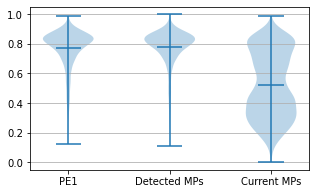

In [12]:
plt.figure(figsize=(5,3))
a = plt.violinplot([pe.probs.astype(float), 
                    dmp.probs.astype(float), 
                    mp.probs.astype(float)],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

# massIVE-KB

In [13]:
class newModel_(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(2100,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)

In [14]:
net_re = newModel_().to(device)
net_re.load_state_dict(torch.load(f'log/PepFormer.pl')['model'])
net_re.eval()

newModel_(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fal

In [15]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
##############################################
# original code
    # with open(file, 'r') as inf:
    #     lines = inf.read().splitlines()
##############################################        
    lines = file
    long_pep_counter=0
    pep_codes=[]
    labels=[]
#     lines.append('X'*79+',0')
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data, torch.tensor(labels)

In [16]:
tmp = pd.read_csv('data/test_diff_hpp.csv')[['peptide', 'label']].drop_duplicates()
tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 81)
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0


In [ ]:
y_pred = pred(test_iter, net_re)
probs = np.array(pred_prob(test_iter, net_re))[:, 1]
acc = evaluate_accuracy(test_iter,net_re)
auc = roc_auc_score(test_label, probs)

In [19]:
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

Test Accuracy: 0.8350869974135904
Test AUC : 0.913151817299528
              precision    recall  f1-score   support

           0     0.8416    0.8308    0.8362     86178
           1     0.8285    0.8395    0.8340     83942

    accuracy                         0.8351    170120
   macro avg     0.8351    0.8351    0.8351    170120
weighted avg     0.8352    0.8351    0.8351    170120



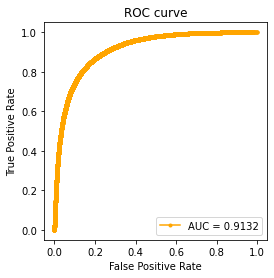

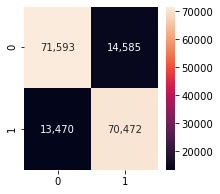

In [18]:
plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [20]:
np.save('log/result_PepFormer_fpr.npy', fpr)
np.save('log/result_PepFormer_tpr.npy', tpr)